# Plotting behavioral parameter space, estimating errors

### Import packages 

In [1]:
import matplotlib.pyplot as plt;
import matplotlib.ticker as ticker
import matplotlib as mpl
import matplotlib.font_manager as font_manager
import matplotlib.colors as colors
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from matplotlib import pyplot
from matplotlib.patches import Circle
from matplotlib.colors import LogNorm

import seaborn as sns
import plotly.graph_objects as go
import fiona
from shapely import geometry
from shapely.geometry import MultiLineString, MultiPolygon, Polygon,Point,polygon,MultiPoint
from shapely.ops import polygonize
from descartes.patch import PolygonPatch

import pickle
import glob
import itertools as it
import numpy as np;
import pandas as pd;
import os, sys,json
import string
from pandas import *
from textwrap import wrap
from os.path import dirname

from scipy.stats import norm
from scipy import stats

parent_dir = (dirname(os.getcwd()))

current_dir = os.getcwd()
sys.path.append("\\".join([parent_dir, 'functions']) )

for mod in ['cal_plots']:
    if mod in sys.modules: 
        del sys.modules[mod]
        
import cal_plots
from cal_plots import *   


### Set defaults for figures

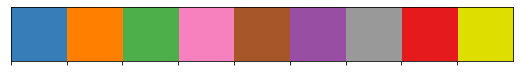

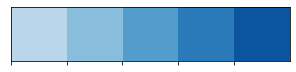

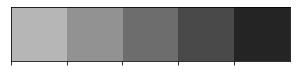

In [2]:
title_font = { 'size':'16', 'color':'black', 'weight':'normal','fontname':'Myriad Pro',
              'verticalalignment':'bottom'} # Bottom vertical alignment for more space
axis_font = { 'size':'14','fontname':'Myriad Pro',}
sub_plot = {'size':'18','color':'black', 'fontname':'Myriad Pro',
            'horizontalalignment':'left', 'verticalalignment':'center'}

CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
cb=sns.color_palette(CB_color_cycle)

sns.palplot(sns.color_palette(cb))

from matplotlib.colors import ListedColormap, LinearSegmentedColormap

cmap1 = sns.cubehelix_palette(rot=-.4,as_cmap=True)
cmap2 = sns.cubehelix_palette(rot=0,as_cmap=True)
cmap3 = sns.cubehelix_palette(rot=.4,as_cmap=True)
cmap4 = sns.cubehelix_palette(start=.1,rot=.6,as_cmap=True)
blue=sns.color_palette("Blues")[4]
blues=sns.color_palette("Blues")[1:10]
sns.palplot(blues)
blacks=sns.color_palette("binary")[1:10]
newcmp = ListedColormap(blacks)
sns.palplot(blacks)
cmap = sns.diverging_palette(220, 40,s=100, as_cmap=True)


### Import sve runs

In [3]:
file = os.path.join(parent_dir, 'inp_files\\SVE_FILES\\sve_core.pickle')
sve_core = pd.read_pickle(file)

### Import SWMM runs    

In [4]:
file = os.path.join(parent_dir, 'out\\cal\\P-2,dur-30min.pickle')
with open(file, 'rb') as handle:
    P_2 = pickle.load(handle)
    
file = os.path.join(parent_dir, 'out\\cal\\P-5,dur-30min.pickle')
with open(file, 'rb') as handle:
    P_5 = pickle.load(handle)

file = os.path.join(parent_dir, 'out\\cal\\P-8,dur-30min.pickle')
with open(file, 'rb') as handle:
    P_8 = pickle.load(handle)

frames=[P_2,P_5,P_8]    

### Combine SWMM and SVE dataframes

In [5]:
#use concat function that combines SVE and SWMM dataframes, calculates error metrics
core_wadc=pd.DataFrame()
core_wadc,swmm=concat(core_wadc,frames,sve_core)

### Get unique scenario values

In [6]:
scenarios = np.unique(core_wadc.scenario)
images = np.unique(core_wadc.image)
ratios=np.unique(core_wadc.p_Ks)
fIs=np.unique(core_wadc.fI)
Ks=np.unique(core_wadc.Ks)
Ps=np.unique(core_wadc.P)

fIs_clipped=[0.1,0.5,0.9]
ratios_clipped=[0.25,1,4]

### Make some quick plots of IF and runoff depth 

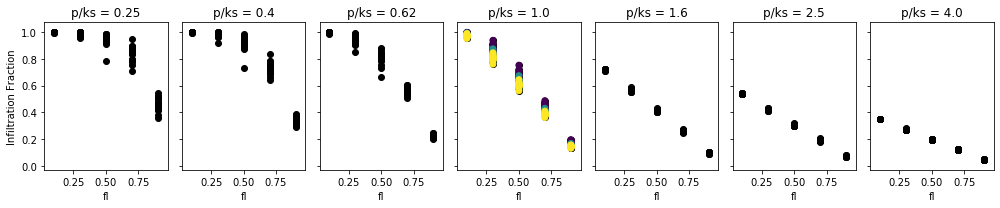

In [7]:
fig, axes = plt.subplots(1,7,figsize = (14,3), sharex = True,  sharey = True)
sve_core['QD']=((1-sve_core['infl_frac'])*(sve_core['p']*10.*30./60.)).astype(float)  
for i,scenario in enumerate(ratios):
    dum = sve_core[sve_core.p_Ks ==scenario]
    axes[i].scatter(dum['fI'],dum['infl_frac'],color='black')
    if scenario==1:
        axes[i].scatter(dum['fI'],dum['infl_frac'],c=dum['p'])
    axes[0].set_ylabel('Infiltration Fraction')
    axes[i].set_xlabel('fI')
    axes[i].set_title("p/ks = " +str(scenario))
plt.tight_layout()

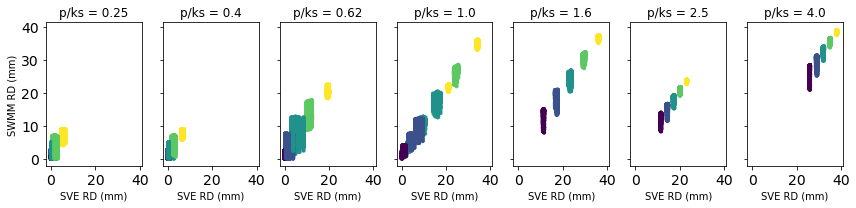

In [8]:
fig, axes = plt.subplots(1,7,figsize = (12,3), sharex = True,  sharey = True)

for i,scenario in enumerate(ratios):
    dum = core_wadc[core_wadc.p_Ks ==scenario]
    axes[i].scatter(dum['RD_sve'],dum['RD_swmm'],c=dum['fI'],s=10)
    axes[0].set_ylabel('SWMM RD (mm)')
    axes[i].set_xlabel('SVE RD (mm)')
    axes[i].set_title("p/ks = " +str(scenario))
    for label in (axes[i].get_xticklabels() + axes[i].get_yticklabels()):
        label.set_fontsize(14)
    plt.tight_layout()

# Plot calibration parameter errors

### Calculate 2d histogram

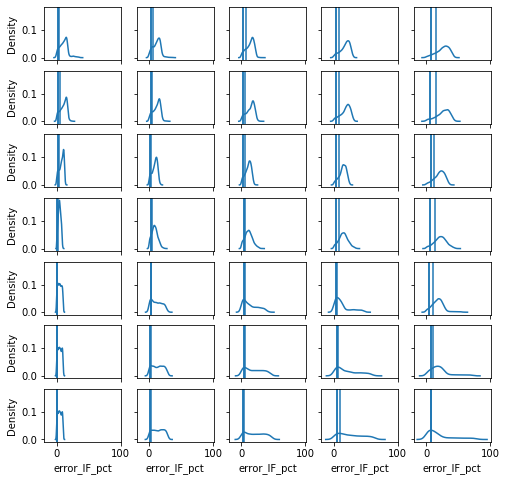

In [9]:
# set x and y bins
binx = np.linspace(0.01-0.005, 0.1+0.005, 11) 
biny = np.linspace(0.0-0.05, 1.0+0.05, 11)

fig, axes = plt.subplots(7,5,figsize = (8,8), sharex = True,  sharey = True)

r=0
hist2d=dict()
for i,scenario in enumerate(ratios[::-1]):
    dum = core_wadc[core_wadc.p_Ks ==scenario]
    dum2=dum.sort_values('fI')
    for j,s in enumerate(fIs):
        dum3 = dum2[dum2.fI ==s]             
        x=dum3['K_width'].values.flatten()
        y=dum3['f_dc'].values.flatten()
        z=abs(dum3['error_IF_pct']).values.flatten() #absolute value of PE_IF
        H, xedges, yedges, binnumbe=stats.binned_statistic_2d(x, y, values =z, statistic='mean', bins=[binx, biny])
        
        # plot histogram of PE_IF 
        sns.kdeplot(abs(dum3['error_IF_pct']),ax=axes[i][j])
        # get data from 2d histogram
        H = H.T # H is the mean of values within each bin


        #5th, 15t, and 25th percentile
        thresh1=np.nanquantile(H,0.05)
        thresh2=np.nanquantile(H,0.15)
        thresh3=np.nanquantile(H,0.25)
        H = np.ma.masked_where(H==0, H) #masking where there was no data
        
        #plot each percentile on the histogram
        axes[i][j].axvline(x=thresh1)
        axes[i][j].axvline(x=thresh2)
        axes[i][j].axvline(x=thresh1)

        hist2d[r]={'scenario':scenario,'fI':s,'H':H,'H_min':np.nanmin(H),'H_mean':np.round(np.nanmean(H),2),
                   'H_max':np.nanmax(H),'thresh1':thresh1,'thresh2':thresh2,'thresh3':thresh3,'xedges':xedges,'yedges':yedges}
        r=r+1

hist2d=DataFrame(hist2d).T

In [10]:
#table of percentile values for each scenario -- for appendix

dum1=hist2d[['scenario','fI','thresh1']].astype(float).copy().sort_index()
dum1['thresh']='05th'
dum1['value']=dum1['thresh1']

dum2=hist2d[['scenario','fI','thresh2']].astype(float).copy().sort_index()
dum2['thresh']='15th'
dum2['value']=dum2['thresh2']

dum3=hist2d[['scenario','fI','thresh3']].astype(float).copy().sort_index()
dum3['thresh']='25th'
dum3['value']=dum3['thresh3']


concat=pd.concat([dum1,dum2,dum3],sort=True)

concat=concat[['scenario','fI','thresh','value']].sort_values('thresh')
table = pd.pivot_table(data=concat,
                    index='fI',
                    values='value',
                    columns=['thresh','scenario'], aggfunc=np.mean)


table=table.round(1).T
print(table.to_latex(index=True))  
# np.mean(table)

\begin{tabular}{llrrrrr}
\toprule
     & fI &  0.1 &  0.3 &  0.5 &   0.7 &   0.9 \\
thresh & scenario &      &      &      &       &       \\
\midrule
05th & 0.25 &  0.3 &  1.2 &  2.8 &   5.8 &   7.2 \\
     & 0.40 &  0.4 &  1.6 &  3.5 &   5.2 &   7.8 \\
     & 0.62 &  0.3 &  2.6 &  3.5 &   3.7 &   5.1 \\
     & 1.00 &  1.2 &  2.8 &  3.4 &   3.5 &   5.7 \\
     & 1.60 &  2.0 &  2.1 &  2.9 &   3.2 &   7.0 \\
     & 2.50 &  1.7 &  2.5 &  3.3 &   3.3 &   6.8 \\
     & 4.00 &  2.5 &  2.4 &  3.2 &   3.5 &   8.4 \\
15th & 0.25 &  1.1 &  2.8 &  4.8 &   9.3 &   8.2 \\
     & 0.40 &  1.2 &  2.6 &  5.7 &   7.4 &  10.8 \\
     & 0.62 &  1.0 &  3.7 &  5.2 &   4.5 &  10.4 \\
     & 1.00 &  2.4 &  4.5 &  5.9 &   8.0 &  13.8 \\
     & 1.60 &  3.1 &  3.8 &  5.0 &   7.6 &  13.1 \\
     & 2.50 &  5.5 &  5.2 &  6.3 &   8.1 &  15.1 \\
     & 4.00 &  3.5 &  6.3 &  6.5 &   8.1 &  15.6 \\
25th & 0.25 &  2.2 &  5.9 &  7.5 &  10.4 &   9.1 \\
     & 0.40 &  2.2 &  5.3 &  8.4 &   8.8 &  12.7 \\
     & 0.62 &  2.

findfont: Font family ['Myriad Pro'] not found. Falling back to DejaVu Sans.


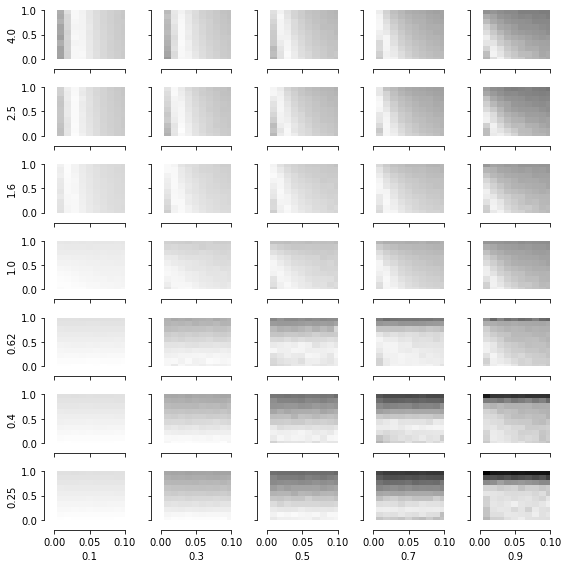

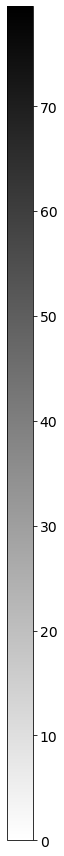

In [11]:
# plot 2d histogram, all for appendix

fig, axes = plt.subplots(7,5,figsize = (8,8), sharex = True,  sharey = True)
axe=axes.ravel()

vmax = np.max(hist2d['H_max']) # get themaximum density value to normalze colors

for i in range(len(hist2d)):
#     i=i+1
    scenario=hist2d['scenario'][i]
    fI=hist2d['fI'][i]
    H=hist2d['H'][i]
    xedges=hist2d['xedges'][i]
    yedges=hist2d['yedges'][i]
    
    axe[i].pcolormesh(xedges, yedges, H,cmap='binary',lw=0,vmin=0,vmax=vmax)
    if i>29:
        axe[i].set_xlabel(fI)
    if (i) % 5 == 0:
        axe[i].set_ylabel(scenario)
        
    for label in (axe[i].get_xticklabels() + axe[i].get_yticklabels()):
        label.set_fontsize(1)  
    axe[i].set_xlim(0,0.1)
    axe[i].set_ylim(0,1)

sns.despine(offset=10, trim=False);
plt.tight_layout()
file = os.path.join(parent_dir, 'figures\\2dhist_all.pdf')
plt.savefig(file)

# add the colorbar to the figure
fig, axes = plt.subplots(1,figsize = (1,12))
sm = plt.cm.ScalarMappable(cmap='binary', norm=plt.Normalize(vmin=0, vmax=vmax))
cbar = fig.colorbar(sm,cax=axes, orientation='vertical',)
for label in (axes.get_xticklabels() + axes.get_yticklabels()):
    label.set_fontname('Myriad Pro')
    label.set_fontsize(14)
plt.tight_layout()
file = os.path.join(parent_dir, 'figures\\colorbar_2dhist.pdf')
plt.savefig(file)

In [68]:
low=np.mean(hist2d['thresh1'])
med=np.mean(hist2d['thresh2'])
high=np.mean(hist2d['thresh3'])
level_max=hist2d['H_max'].max()
levels=[0,low,med,high,level_max+1]
levels

[0, 3.497873386998006, 6.4490727757044946, 8.93582410575312, 80.52230679607548]

### Plot contours associated with high, medium, and low density levels

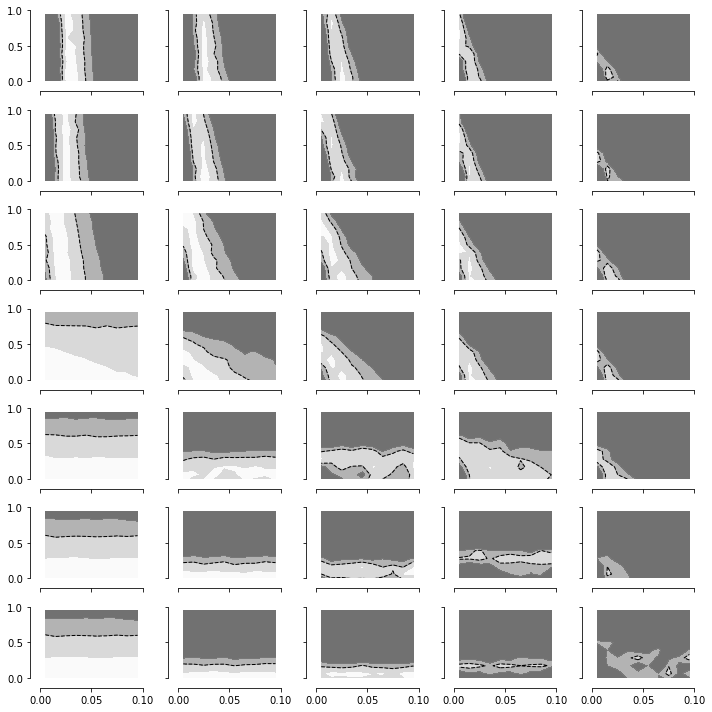

In [69]:
## plot contours - all for appendix

poly_dict=dict()

fig, axes = plt.subplots(7,5,figsize = (10,10), sharex = True,  sharey = True)


for i,scenario in enumerate(ratios[::-1]):
    dum = hist2d[hist2d.scenario ==scenario]
    dum2=dum.sort_values('fI')
    for j,s in enumerate(fIs):
        dum3 = dum2[dum2.fI ==s]
        
        levels=[0,low,med,high,level_max+1]
        


        cs = axes[i][j].contourf(np.unique(dum3.xedges)[0][:-1],
                                 np.unique(dum3.yedges)[0][:-1],
                                 np.unique(dum3.H)[0], 
                                 levels=levels,
                                 vmin=0, vmax=level_max+1,
#                                  norm=colors.LogNorm(vmin=.5, vmax=level_max+1),
                                 cmap='binary')
        
            
        cs = axes[i][j].contourf(np.unique(dum3.xedges)[0][:-1],
                                 np.unique(dum3.yedges)[0][:-1],
                                 np.unique(dum3.H)[0], 
                                 levels=[med,high],
                                 colors='grey',zorder=2,alpha=0.5)


        cs = axes[i][j].contourf(np.unique(dum3.xedges)[0][:-1],
                         np.unique(dum3.yedges)[0][:-1],
                         np.unique(dum3.H)[0], 
                         levels=[low,med],
                         colors='grey',zorder=3,alpha=0.2)

            
        cs = axes[i][j].contour(np.unique(dum3.xedges)[0][:-1],
                                 np.unique(dum3.yedges)[0][:-1],
                                 np.unique(dum3.H)[0], 
                                 levels=[0,med],
                                 linewidths=1,
                                linestyles='dashed',
                                    colors='black',zorder=4)

#         for label in (axes[i][j].get_xticklabel() + axes[i][j].get_yticklabels()):
#             label.set_fontsize(1)  
            
#         axes[0][j].set_title(s, **axis_font)
#         axes[i][0].set_ylabel(scenario,**axis_font)
        axes[i][j].set_xlim(0,0.1)
        axes[i][j].set_ylim(0,1.)


sns.despine(offset=10, trim=False);
plt.tight_layout()
file = os.path.join(parent_dir, 'figures\\contours_all_appendix.pdf')
plt.savefig(file)

###  Extract behavioral parameter space

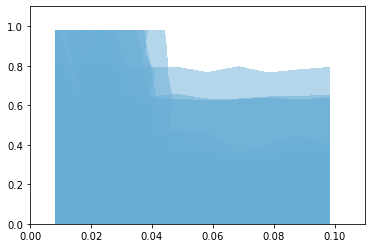

In [70]:
#calculate parameter space, save polygons as dataframe
# med = 11

poly_all=dict()
r=0

for i,scenario in enumerate(ratios[::-1]):
    dum = hist2d[hist2d.scenario ==scenario]
    dum2=dum.sort_values('fI')
    for j,s in enumerate(fIs):
        dum3 = dum2[dum2.fI ==s]
        levels=[0,med]
        xwidth=np.unique(dum3.xedges)[0][2:3]-np.unique(dum3.xedges)[0][1:2]
        ywidth=np.unique(dum3.yedges)[0][2:3]-np.unique(dum3.yedges)[0][1:2]
        
        cs = plt.contourf(np.unique(dum3.xedges)[0][1:]-2*xwidth/3.,
                                 np.unique(dum3.yedges)[0][1:]-2*ywidth/3.,
                                 np.unique(dum3.H)[0], 
                                 levels=levels,
                                 cmap='Blues',alpha=0.5)
        plt.xlim(0.0,0.11)
        plt.ylim(0.0,1.1)

        # loop over collections (and polygons in each collection), store in list for fiona
        area=0
        geometries_list=[]
        
        for k in range(len(cs.collections)):
            area=area
            for j in range(len(cs.collections[k].get_paths())):
                p = cs.collections[k].get_paths()[j]
                v = p.vertices
                x = v[:,0]
                y = v[:,1]
                poly = polygon.Polygon([(k[0], k[1]) for k in zip(x,y)])
                geometries_list+=[poly]
            polygons = MultiPolygon(geometries_list).buffer(0)

        
        poly_all[r]={'scenario':scenario,'fI':s,'poly':polygons,'area':polygons.area}
        r=r+1

poly_df=DataFrame(poly_all).T

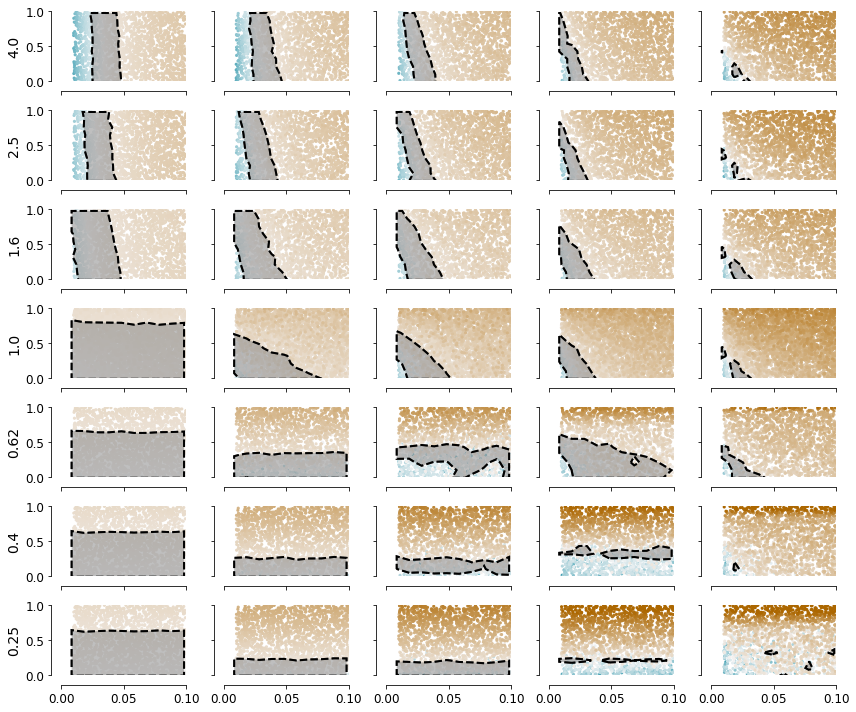

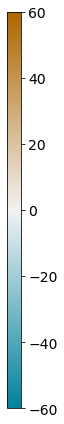

In [71]:
# plot parameter space and errors 

fig, axes = plt.subplots(7,5,figsize = (12,10), sharex = True,  sharey = True)

for i,scenario in enumerate(ratios[::-1]):
    dum = core_wadc[core_wadc.p_Ks ==scenario]
    dum_poly = poly_df[poly_df.scenario ==scenario]
    dum2=dum.sort_values('fI')
    for j,s in enumerate(fIs):
        dum3 = dum2[dum2.fI ==s].reset_index()
        dum2_poly = dum_poly[dum_poly.fI ==s]
        poly= np.unique(dum2_poly['poly'])[0]
        dum3=dum3.sort_values('error_IF_pct',ascending=True)
        poly= np.unique(dum2_poly['poly'])[0]
      
        pcm=axes[i][j].scatter(dum3['K_width'], dum3['f_dc'],c=dum3['error_IF_pct'],cmap=cmap,lw=0,vmin=-60, vmax=60,s=10)

        patch = PolygonPatch(poly, edgecolor='black',facecolor='grey',zorder=1,lw=2,ls='--',label=s,alpha=0.5)
        patch2 = PolygonPatch(poly, edgecolor='black',facecolor=None,Fill=False,zorder=1,lw=2,ls='--',label=s)
        axes[i][j].add_patch(patch)
        axes[i][j].add_patch(patch2)
        axes[i][j].xaxis.set_major_locator(ticker.MultipleLocator(.05))
        
        
        axes[i][0].set_ylabel(str(scenario),**axis_font)
        axes[i][j].set_xlabel('')
        axes[i][j].set_xlim(0,0.1)
        axes[i][j].set_ylim(0,1.)
        
sns.despine(offset=10, trim=False);
axe=axes.ravel()
for a in axe:
    for label in (a.get_xticklabels() + a.get_yticklabels()):
        label.set_fontsize(12)  
plt.tight_layout()
file = os.path.join(parent_dir, 'figures\\2param_err.pdf')
plt.savefig(file)

fig, axes = plt.subplots(1,figsize = (1,6))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=-60, vmax=60))
cbar = fig.colorbar(sm,cax=axes, orientation='vertical',)
for label in (axes.get_xticklabels() + axes.get_yticklabels()):
    label.set_fontsize(14)
plt.tight_layout()
file = os.path.join(parent_dir, 'figures\\2param_color.pdf')
plt.savefig(file)

### Calculate actual change in IF   across transitions as "observed" by the SVE

In [72]:
core_wadc['PKs_fI']=core_wadc['fI']*core_wadc['p_Ks']
runs = np.unique(core_wadc.PKs_fI)

sve_trans= dict()
       
r=0
for j,run in enumerate(runs):
    dum1 = core_wadc[core_wadc.PKs_fI ==run]
    fI0=np.unique(dum1['fI'])[0]
    P_Ks0=np.unique(dum1['p_Ks'])[0]
    SVE_IF0=np.mean(dum1['infl_frac'])
    SVE_RD0=np.mean(dum1['RD_sve'])
    SVE_RR0=np.mean(dum1['RR_sve'])
    
    for jj,runn in enumerate(runs):
        dum3 = core_wadc[core_wadc.PKs_fI ==runn]
        fI1=np.unique(dum3['fI'])[0]
        P_Ks1=np.unique(dum3['p_Ks'])[0]
        SVE_IF1=np.mean(dum3['infl_frac'])
        SVE_RD1=np.mean(dum3['RD_sve'])
        SVE_RR1=np.mean(dum3['RR_sve'])


        r=r+1
        sve_trans[r]={'fI0':fI0,'P_Ks0':P_Ks0,'fI1':fI1,'P_Ks1':P_Ks1,'SVE_IF1': SVE_IF1,'SVE_IF0': SVE_IF0,
                    'SVE_RD1': SVE_RD1,'SVE_RD0': SVE_RD0,
                      'SVE_RR1': SVE_RR1,'SVE_RR0': SVE_RR0}

sve_transition=DataFrame(sve_trans).T

In [73]:
sve_transition['P_Ks1']=sve_transition['P_Ks1'].astype(float)
sve_transition['P_Ks0']=sve_transition['P_Ks0'].astype(float)
sve_transition['fI1']=sve_transition['fI1'].astype(float)
sve_transition['fI0']=sve_transition['fI0'].astype(float)

In [74]:
sve_transition['RD_change']=(sve_transition['SVE_RD1']-sve_transition['SVE_RD0'])/sve_transition['SVE_RD0']*100
sve_transition['fI_change']=(sve_transition['fI1']-sve_transition['fI0'])
sve_transition['pKs_change']=(sve_transition['P_Ks1']-sve_transition['P_Ks0'])
dd4=sve_transition[sve_transition['fI_change']>0].copy()
# dd4=dd4[dd4['fI0']==0.7].copy()
dd5=dd4[dd4['pKs_change']==0].copy()
dd5['RD_change_per_imp']=dd5['RD_change']/(dd5['fI_change']*100)
dd5['RD_change_per_imp'].mean()
# dd5.head()

568.0732243424958

### Calculate transferability, T

In [75]:
#calculate intersection - probability
#this takes a while to run!

cmap1=sns.cubehelix_palette(7)
cmap2=sns.cubehelix_palette(35,start=2)
poly_df['PKs_fI']=poly_df['fI']*poly_df['scenario']

runs = np.unique(poly_df.PKs_fI)

#loops through each run, pairs it with every other run, calculates the intersection of the behavioral parameter spaces
# and computes the errors associated with transferring behavioral sets from initial conditoins to future conditions
intersect=dict()
r=0
poly_df=poly_df.sort_values('scenario')
for j,run in enumerate(runs):
    dum1 = poly_df[poly_df.PKs_fI ==run]
    fI0=np.unique(dum1['fI'])[0]
    P_Ks0=np.unique(dum1['scenario'])[0]
    init_poly= np.unique(dum1['poly'])[0]

    for jj,runn in enumerate(runs):
        dum3 = poly_df[poly_df.PKs_fI ==runn]
        future_poly=np.unique(dum3['poly'])[0]
        fI1=np.unique(dum3['fI'])[0]
        P_Ks1=np.unique(dum3['scenario'])[0]
        
        
        final_pts=core_wadc[core_wadc.fI ==fI1]
        final_pts=final_pts[final_pts.p_Ks ==P_Ks1].sort_values('error_IF_pct',ascending=False)
        
        point_list_IF =[]
        point_list_IF_abs=[]
        point_list_RR_abs=[]
        point_list_RD_abs=[]
        point_list_RD_pct=[]
        
        point_SVE_IF=[]
       
        for index,row in final_pts.iterrows():
            
            K_width=row['K_width']
            f_dc=row['f_dc']
            
            error_IF_pct=row['error_IF_pct']
            error_IF_abs=row['error_IF_abs']
            error_RR_abs=row['error_RR_abs']
            error_RD_abs=row['error_RD_abs']            
            error_RD_pct=row['error_RD_pct']            
            
            orig_IF = (K_width,f_dc,error_IF_pct)
            point_list_IF=point_list_IF+[orig_IF]
            
            orig_IF_abs = (K_width,f_dc,error_IF_abs)
            point_list_IF_abs=point_list_IF_abs+[orig_IF_abs]
            
            orig_RR_abs = (K_width,f_dc,error_RR_abs)
            point_list_RR_abs=point_list_RR_abs+[orig_RR_abs]
            
            orig_RD_abs = (K_width,f_dc,error_RD_abs)
            point_list_RD_abs=point_list_RD_abs+[orig_RD_abs]
            
            orig_RD_pct = (K_width,f_dc,error_RD_pct)
            point_list_RD_pct=point_list_RD_pct+[orig_RD_pct]            
           
         
        multi_pts_IF = MultiPoint(point_list_IF)
        multi_pts_IF_abs = MultiPoint(point_list_IF_abs)
        multi_pts_RR_abs = MultiPoint(point_list_RR_abs)
        multi_pts_RD_abs = MultiPoint(point_list_RD_abs)
        multi_pts_RD_pct = MultiPoint(point_list_RD_pct)
        
        error_IF=[]
        int_points=[]
        for p in multi_pts_IF:
            if p.within(init_poly):
                int_points=int_points+[p]
                error_IF=error_IF+[(p.z)]


        error_IF_abs=[]
        int_points=[]
        for p in multi_pts_IF_abs:
            if p.within(init_poly):
                int_points=int_points+[p]
                error_IF_abs=error_IF_abs+[(p.z)]
        
        error_RR_abs=[]
        int_points=[]
        for p in multi_pts_RR_abs:
            if p.within(init_poly):
                int_points=int_points+[p]
                error_RR_abs=error_RR_abs+[(p.z)]  
                
        error_RD_abs=[]
        int_points=[]
        for p in multi_pts_RD_abs:
            if p.within(init_poly):
                int_points=int_points+[p]
                error_RD_abs=error_RD_abs+[(p.z)]

        error_RD_pct=[]
        int_points=[]
        for p in multi_pts_RD_pct:
            if p.within(init_poly):
                int_points=int_points+[p]
                error_RD_pct=error_RD_pct+[(p.z)]

                
        r=r+1
        try:
            intersect[r]={'fI0':fI0,'P_Ks0':P_Ks0,'fI1':fI1,'P_Ks1':P_Ks1,
                        'intersect':init_poly.intersection(future_poly).area/(init_poly.area),
                          'init_a':init_poly.area,'future_a':future_poly.area,
                          "error_IF":error_IF,
                          "error_IF_abs":error_IF_abs,
                          "error_RR_abs":error_RR_abs,
                          "error_RD_abs":error_RD_abs,
                          "error_RD_pct":error_RD_pct}
        except:
            print('empty')

intersect_core=DataFrame(intersect).T

In [76]:
# merge SWMM behavioral parameter space transfer with SVE transitions
# useful for benchmarking transfer errors against actual change
intersect = pd.merge(intersect_core, sve_transition,  how='outer',on=['P_Ks1', 'P_Ks0','fI1','fI0'])

In [77]:
#calculate transition metrics
intersect['P_Ks1']=intersect['P_Ks1'].astype(float)
intersect['P_Ks0']=intersect['P_Ks0'].astype(float)
intersect['fI1']=intersect['fI1'].astype(float)
intersect['fI0']=intersect['fI0'].astype(float)
intersect['intersect']=intersect['intersect'].astype(float)
intersect['init_a']=intersect['init_a'].astype(float)

intersect['d_PKs']=np.round((intersect['P_Ks1'] - intersect['P_Ks0']),3)
intersect['d_fI']=np.round((intersect['fI1']-intersect['fI0']),2)

intersect['SVE_IF_pct']=((intersect['SVE_IF1']-intersect['SVE_IF0'])/intersect['SVE_IF0'])*100
intersect['SVE_IF_abs']=((intersect['SVE_IF1']-intersect['SVE_IF0']))
intersect['SVE_RD_abs']=((intersect['SVE_RD1']-intersect['SVE_RD0']))

intersect['fI0']=np.round((intersect['fI0']),2)

###  Plot transferability T as a function of d_PKs and d_fI

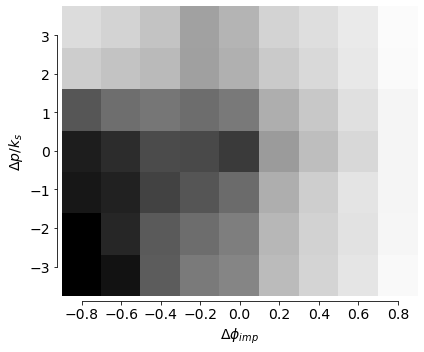

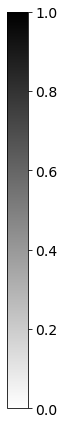

In [78]:
#plot probabilities

fig, axes = plt.subplots(1,figsize = (6,5), sharex = True,  sharey = True)

binx=[-0.9,-0.7,-0.5,-0.3,-0.1,0.1,0.3,0.5,0.7,0.9]
biny = np.linspace(-3.75,3.75, 8)

x=intersect['d_fI'].values.flatten()
y=intersect['d_PKs'].values.flatten()
z=intersect['intersect'].values.flatten()
#calculate mean T within each bin
H, xedges, yedges, binnumbe=stats.binned_statistic_2d(x, y, values =z, statistic='mean', bins=[binx, biny])
# get data from 2d histogram
H = H.T # H is the density of values within each bin
plt.pcolormesh(xedges, yedges, H,lw=0,cmap='binary',vmin=0, vmax=1)

x_labels=[]
for x in binx:
    x_labels=x_labels+[x+0.1]
axes.set_xticks(x_labels[:-1])

axes.set_xlabel('$Δ{ɸ_{imp}}$',**axis_font)
axes.set_ylabel('$Δ{p/k_s}$',**axis_font)
axes.tick_params(labelsize=14)
sns.despine(offset=5,trim=True);
plt.tight_layout()
file = os.path.join(parent_dir, 'figures\\probablity_change.pdf')
plt.savefig(file)

fig, axes = plt.subplots(1,figsize = (1,6))
sm = plt.cm.ScalarMappable(cmap="binary", norm=plt.Normalize(vmin=0, vmax=1))
cbar = fig.colorbar(sm,cax=axes, orientation='vertical',)
for label in (axes.get_xticklabels() + axes.get_yticklabels()):
    label.set_fontsize(14)
plt.tight_layout()
file = os.path.join(parent_dir, 'figures\\colorbar2.pdf')
plt.savefig(file)

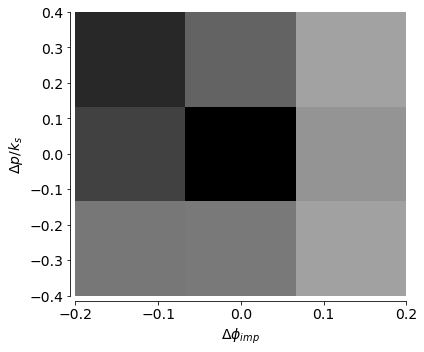

In [79]:
#plot probabilities zoom in

fig, axes = plt.subplots(1,figsize = (6,5), sharex = True,  sharey = True)
binx = np.linspace(-.2, 0.2,4) 
biny = np.linspace(-0.4,  0.4,4)


x=intersect['d_fI'].values.flatten()
y=intersect['d_PKs'].values.flatten()
z=intersect['intersect'].values.flatten()
H, xedges, yedges, binnumbe=stats.binned_statistic_2d(x, y, values =z, statistic='mean', bins=[binx, biny])
#         # get data from 2d histogram
H = H.T # H is the density of values within each bin
plt.pcolormesh(xedges, yedges, H,lw=0,cmap='binary',vmin=0, vmax=1)

axes.set_xlabel('$Δ{ɸ_{imp}}$',**axis_font)
axes.set_ylabel('$Δ{p/k_s}$',**axis_font)
axes.tick_params(labelsize=14)
sns.despine(offset=5);
plt.tight_layout()
file = os.path.join(parent_dir, 'figures\\probablity_change_zoom.pdf')
plt.savefig(file)


# Plot changes in IF and RD across transitions

In [80]:
intersect=intersect.dropna()

## Plots of actual change in IF (%), IF (abs), and RD (abs) as a function of d_pKs and d_fI

### Actual change in IF %

2080.50165394239
-95.41389937406385


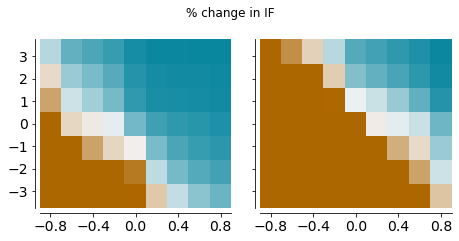

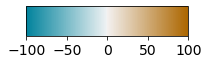

In [81]:
# Use error_grid function to compute confidence intervals
intersect_2 = error_grid('SVE_IF_pct',intersect)

print(np.max(intersect_2['max_err']))
print(np.min(intersect_2['min_err']))


fig, axes = plt.subplots(1,2, figsize = (6.5,3),sharex = True,  sharey = True)
intersect_2=intersect_2.sort_values('fI0',ascending=False)
fig.subplots_adjust(hspace = 5)
fig.suptitle('% change in IF',y=1.1)


binx=[-0.9,-0.7,-0.5,-0.3,-0.1,0.1,0.3,0.5,0.7,0.9]
biny = np.linspace(-3.75,3.75, 8)

# intersect['y'] = (intersect['future_a']/np.max(intersect['future_a'])-(intersect['init_a']/np.max(intersect['init_a'])))
intersect_2['x'] = (intersect_2['fI1']-intersect_2['fI0']).values.flatten()
x=intersect_2['x'].astype(float).values.flatten()
intersect_2['y'] = (intersect_2['P_Ks1']-intersect_2['P_Ks0']).values.flatten()
y=intersect_2['y'].astype(float).values.flatten()


z = intersect_2['min_err'].astype(float).values.flatten()
H, xedges, yedges, binnumbe=stats.binned_statistic_2d(x, y, values =z, statistic='min', bins=[binx, biny])
H_sve_low_pct= H.T # H is the density of values within each bin
a=axes[0].pcolormesh(xedges, yedges, H_sve_low_pct,lw=0,cmap=cmap,vmin=-100,vmax=100)


z = intersect_2['max_err'].astype(float).values.flatten()
H, xedges, yedges, binnumbe=stats.binned_statistic_2d(x, y, values =z, statistic='max', bins=[binx, biny])
H_sve_high_pct = H.T # H is the density of values within each bin
a=axes[1].pcolormesh(xedges, yedges, H_sve_high_pct,lw=0,cmap=cmap,vmin=-100,vmax=100)

axes[1].set_xticks([-0.8,-0.4,0,0.4,0.8])

# plt.xlim(-1,1)
# plt.ylim(-3.25,3.25)

sns.despine(offset=5);

axe=axes.ravel()
for a in axe:
    for label in (a.get_xticklabels() + a.get_yticklabels()):
        label.set_fontsize(14)   

plt.tight_layout()
fig.subplots_adjust(wspace = .15)
file = os.path.join(parent_dir, 'figures\\pct_change_IF.pdf')
# plt.savefig(file)

fig, axes = plt.subplots(1,figsize = (3,1))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=-100., vmax=100.))
cbar = fig.colorbar(sm,orientation="horizontal",cax=axes )
for label in (axes.get_xticklabels() + axes.get_yticklabels()):
    label.set_fontsize(14)
plt.tight_layout()
file = os.path.join(parent_dir, 'figures\\pct_change_IF_colorbar.pdf')
# plt.savefig(file)

### Actual change in IF - absolute

0.9540922893290436
-0.9540922893290436


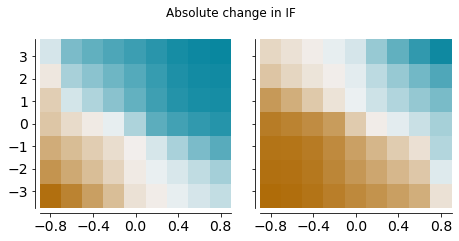

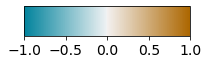

In [82]:
intersect_2 = error_grid('SVE_IF_abs',intersect)

print(np.max(intersect_2['max_err']))
print(np.min(intersect_2['min_err']))

fig, axes = plt.subplots(1,2, figsize = (6.5,3),sharex = True,  sharey = True)
intersect=intersect_2.sort_values('fI0',ascending=False)
fig.suptitle('Absolute change in IF',y=1.1)
fig.subplots_adjust(hspace = 5)


binx=[-0.9,-0.7,-0.5,-0.3,-0.1,0.1,0.3,0.5,0.7,0.9]
biny = np.linspace(-3.75,3.75, 8)

# intersect['y'] = (intersect['future_a']/np.max(intersect['future_a'])-(intersect['init_a']/np.max(intersect['init_a'])))
intersect_2['x'] = (intersect_2['fI1']-intersect_2['fI0']).values.flatten()
x=intersect_2['x'].astype(float).values.flatten()
intersect_2['y'] = (intersect_2['P_Ks1']-intersect_2['P_Ks0']).values.flatten()
y=intersect_2['y'].astype(float).values.flatten()


z = intersect_2['min_err'].astype(float).values.flatten()
H, xedges, yedges, binnumbe=stats.binned_statistic_2d(x, y, values =z, statistic='min', bins=[binx, biny])
H_IF_abs_low = H.T # H is the density of values within each bin
a=axes[0].pcolormesh(xedges, yedges, H_IF_abs_low,lw=0,cmap=cmap,vmin=-1,vmax=1)

z = intersect_2['max_err'].astype(float).values.flatten()
H, xedges, yedges, binnumbe=stats.binned_statistic_2d(x, y, values =z, statistic='max', bins=[binx, biny])
H_IF_abs_high = H.T # H is the density of values within each bin
a=axes[1].pcolormesh(xedges, yedges, H_IF_abs_high,lw=0,cmap=cmap,vmin=-1,vmax=1)

axes[1].set_xticks([-0.8,-0.4,0,0.4,0.8])
# plt.xlim(-1,1)
# plt.ylim(-3.25,3.25)

sns.despine(offset=5);

axe=axes.ravel()
for a in axe:
    for label in (a.get_xticklabels() + a.get_yticklabels()):
        label.set_fontsize(14)   

    

plt.tight_layout()
fig.subplots_adjust(wspace = .15)
file = os.path.join(parent_dir, 'figures\\abs_change_IF.pdf')
# plt.savefig(file)

fig, axes = plt.subplots(1,figsize = (3,1))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=-1., vmax=1.))
cbar = fig.colorbar(sm,orientation="horizontal",cax=axes )
for label in (axes.get_xticklabels() + axes.get_yticklabels()):
    label.set_fontsize(14)
plt.tight_layout()
file = os.path.join(parent_dir, 'figures\\abs_change_IF_colorbar.pdf')
# plt.savefig(file)

### Actual change in runoff depth 

38.16516005139938
-38.16516005139938


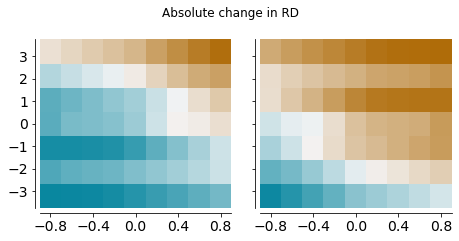

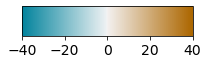

In [83]:
intersect_2 = error_grid('SVE_RD_abs',intersect)

print(np.max(intersect_2['max_err']))
print(np.min(intersect_2['min_err']))


fig, axes = plt.subplots(1,2, figsize = (6.5,3),sharex = True,  sharey = True)
intersect=intersect_2.sort_values('fI0',ascending=False)
fig.subplots_adjust(hspace = 5)
fig.suptitle('Absolute change in RD',y=1.1)


binx=[-0.9,-0.7,-0.5,-0.3,-0.1,0.1,0.3,0.5,0.7,0.9]
biny = np.linspace(-3.75,3.75, 8)

# intersect['y'] = (intersect['future_a']/np.max(intersect['future_a'])-(intersect['init_a']/np.max(intersect['init_a'])))
intersect_2['x'] = (intersect_2['fI1']-intersect_2['fI0']).values.flatten()
x=intersect_2['x'].astype(float).values.flatten()
intersect_2['y'] = (intersect_2['P_Ks1']-intersect_2['P_Ks0']).values.flatten()
y=intersect_2['y'].astype(float).values.flatten()


z = intersect_2['min_err'].astype(float).values.flatten()
H, xedges, yedges, binnumbe=stats.binned_statistic_2d(x, y, values =z, statistic='min', bins=[binx, biny])
H_RD_abs_low = H.T # H is the density of values within each bin
a=axes[0].pcolormesh(xedges, yedges, H_RD_abs_low,lw=0,cmap=cmap,vmin=-40,vmax=40)

z = intersect_2['max_err'].astype(float).values.flatten()
H, xedges, yedges, binnumbe=stats.binned_statistic_2d(x, y, values =z, statistic='max', bins=[binx, biny])
H_RD_abs_high = H.T # H is the density of values within each bin
a=axes[1].pcolormesh(xedges, yedges, H_RD_abs_high,lw=0,cmap=cmap,vmin=-40,vmax=40)

axes[1].set_xticks([-0.8,-0.4,0,0.4,0.8])

# plt.xlim(-1,1)
# plt.ylim(-3.25,3.25)

sns.despine(offset=5);

axe=axes.ravel()
for a in axe:
    for label in (a.get_xticklabels() + a.get_yticklabels()):
        label.set_fontsize(14)   

    
plt.tight_layout()
fig.subplots_adjust(wspace = .15)
file = os.path.join(parent_dir, 'figures\\abs_change_RD.pdf')
# plt.savefig(file)

fig, axes = plt.subplots(1,figsize = (3,1))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=-40., vmax=40.))
cbar = fig.colorbar(sm,orientation="horizontal",cax=axes )
for label in (axes.get_xticklabels() + axes.get_yticklabels()):
    label.set_fontsize(14)
plt.tight_layout()
file = os.path.join(parent_dir, 'figures\\abs_change_RD_colorbar.pdf')
# plt.savefig(file)


# Plots of errors between SWMM and SVE as a function of d_pKs and d_fI 


### % Error in IF

68.04341819665908
-35.933129775816376


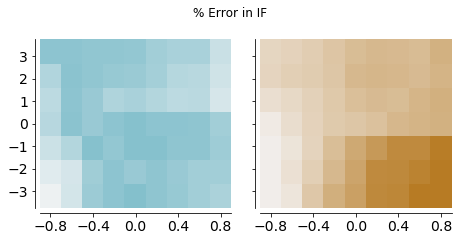

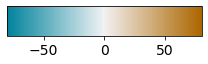

In [84]:
intersect_2 = error_grid('error_IF',intersect)

print(np.max(intersect_2['max_err']))
print(np.min(intersect_2['min_err']))

fig, axes = plt.subplots(1,2, figsize = (6.5,3),sharex = True,  sharey = True)
intersect=intersect_2.sort_values('fI0',ascending=False)
fig.subplots_adjust(hspace = 5)
fig.suptitle('% Error in IF',y=1.1)


binx=[-0.9,-0.7,-0.5,-0.3,-0.1,0.1,0.3,0.5,0.7,0.9]
biny = np.linspace(-3.75,3.75, 8)

# intersect['y'] = (intersect['future_a']/np.max(intersect['future_a'])-(intersect['init_a']/np.max(intersect['init_a'])))
intersect_2['x'] = (intersect_2['fI1']-intersect_2['fI0']).values.flatten()
x=intersect_2['x'].astype(float).values.flatten()
intersect_2['y'] = (intersect_2['P_Ks1']-intersect_2['P_Ks0']).values.flatten()
y=intersect_2['y'].astype(float).values.flatten()


z = intersect_2['min_err'].astype(float).values.flatten()
H, xedges, yedges, binnumbe=stats.binned_statistic_2d(x, y, values =z, statistic='min', bins=[binx, biny])
H = H.T # H is the density of values within each bin
a=axes[0].pcolormesh(xedges, yedges, H,lw=0,cmap=cmap,vmin=-80,vmax=80)

z = intersect_2['max_err'].astype(float).values.flatten()
H, xedges, yedges, binnumbe=stats.binned_statistic_2d(x, y, values =z, statistic='max', bins=[binx, biny])
H = H.T # H is the density of values within each bin
a=axes[1].pcolormesh(xedges, yedges, H,lw=0,cmap=cmap,vmin=-80,vmax=80)

axes[1].set_xticks([-0.8,-0.4,0,0.4,0.8])

# plt.xlim(-1,1)
# plt.ylim(-3.25,3.25)

sns.despine(offset=5);

axe=axes.ravel()
for a in axe:
    for label in (a.get_xticklabels() + a.get_yticklabels()):
        label.set_fontsize(14)   


    
plt.tight_layout()
fig.subplots_adjust(wspace = .15)
file = os.path.join(parent_dir, 'figures\\error_IF_maxmin.pdf')
# plt.savefig(file)

fig, axes = plt.subplots(1,figsize = (3,1))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=-80, vmax=80))
cbar = fig.colorbar(sm,orientation="horizontal",cax=axes )
for label in (axes.get_xticklabels() + axes.get_yticklabels()):
    label.set_fontsize(14)
plt.tight_layout()
file = os.path.join(parent_dir, 'figures\\IF_colorbar3.pdf')
# plt.savefig(file)


### Absolute IF error

-0.2593533013124685
0.5306658452898863


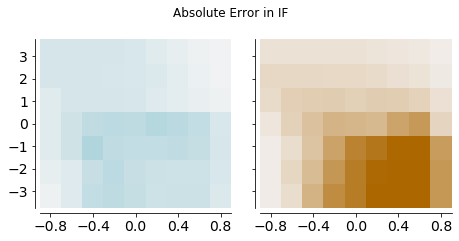

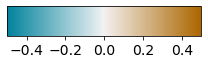

In [85]:
intersect_2 = error_grid('error_IF_abs',intersect)

print(np.min(intersect_2['min_err']))
print(np.max(intersect_2['max_err']))

fig, axes = plt.subplots(1,2, figsize = (6.5,3),sharex = True,  sharey = True)
intersect=intersect_2.sort_values('fI0',ascending=False)
fig.subplots_adjust(hspace = 5)
fig.suptitle('Absolute Error in IF',y=1.1)

binx=[-0.9,-0.7,-0.5,-0.3,-0.1,0.1,0.3,0.5,0.7,0.9]
biny = np.linspace(-3.75,3.75, 8)

intersect_2['x'] = (intersect_2['fI1']-intersect_2['fI0']).values.flatten()
x=intersect_2['x'].astype(float).values.flatten()
intersect_2['y'] = (intersect_2['P_Ks1']-intersect_2['P_Ks0']).values.flatten()
y=intersect_2['y'].astype(float).values.flatten()


z = intersect_2['min_err'].astype(float).values.flatten()
H, xedges, yedges, binnumbe=stats.binned_statistic_2d(x, y, values =z, statistic='min', bins=[binx, biny])
H = H.T # H is the density of values within each bin
a=axes[0].pcolormesh(xedges, yedges, H,lw=0,cmap=cmap,vmin=-1,vmax=1)

z = intersect_2['max_err'].astype(float).values.flatten()
H, xedges, yedges, binnumbe=stats.binned_statistic_2d(x, y, values =z, statistic='max', bins=[binx, biny])
H = H.T # H is the density of values within each bin
a=axes[1].pcolormesh(xedges, yedges, H,lw=0,cmap=cmap,vmin=-.5,vmax=.5)

axes[1].set_xticks([-0.8,-0.4,0,0.4,0.8])

# plt.xlim(-1,1)
# plt.ylim(-3.25,3.25)

sns.despine(offset=5);

axe=axes.ravel()
for a in axe:
    for label in (a.get_xticklabels() + a.get_yticklabels()):
        label.set_fontsize(14)   

plt.tight_layout()
fig.subplots_adjust(wspace = .15)
file = os.path.join(parent_dir, 'figures\\error_IFabs_maxmin.pdf')
# plt.savefig(file)

fig, axes = plt.subplots(1,figsize = (3,1))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=-.5, vmax=.5))
cbar = fig.colorbar(sm,orientation="horizontal",cax=axes )
for label in (axes.get_xticklabels() + axes.get_yticklabels()):
    label.set_fontsize(14)
plt.tight_layout()
file = os.path.join(parent_dir, 'figures\\IFabs_colorbar3.pdf')
# plt.savefig(file)


### Runoff depth

4.904360303163739
-7.5830789256508435


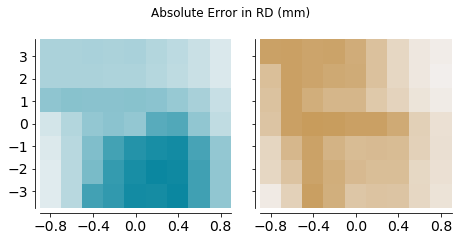

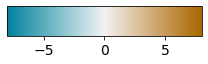

In [86]:
intersect_2 = error_grid('error_RD_abs',intersect)

print(np.max(intersect_2['max_err']))
print(np.min(intersect_2['min_err']))

fig, axes = plt.subplots(1,2, figsize = (6.5,3),sharex = True,  sharey = True)
intersect_2=intersect_2.sort_values('fI0',ascending=False)
fig.subplots_adjust(hspace = 5)
fig.suptitle('Absolute Error in RD (mm)',y=1.1)

binx=[-0.9,-0.7,-0.5,-0.3,-0.1,0.1,0.3,0.5,0.7,0.9]
biny = np.linspace(-3.75,3.75, 8)

intersect_2['x'] = (intersect_2['fI1']-intersect_2['fI0']).values.flatten()
x=intersect_2['x'].astype(float).values.flatten()
intersect_2['y'] = (intersect_2['P_Ks1']-intersect_2['P_Ks0']).values.flatten()
y=intersect_2['y'].astype(float).values.flatten()


z = intersect_2['min_err'].astype(float).values.flatten()
H, xedges, yedges, binnumbe=stats.binned_statistic_2d(x, y, values =z, statistic='min', bins=[binx, biny])
H = H.T # H is the density of values within each bin
a=axes[0].pcolormesh(xedges, yedges, H,lw=0,cmap=cmap,vmin=-8,vmax=8)


z = intersect_2['max_err'].astype(float).values.flatten()
H, xedges, yedges, binnumbe=stats.binned_statistic_2d(x, y, values =z, statistic='max', bins=[binx, biny])
H = H.T # H is the density of values within each bin
a=axes[1].pcolormesh(xedges, yedges, H,lw=0,cmap=cmap,vmin=-8,vmax=8)

axes[1].set_xticks([-0.8,-0.4,0,0.4,0.8])

# plt.xlim(-1,1)
# plt.ylim(-3.25,3.25)

sns.despine(offset=5);

axe=axes.ravel()
for a in axe:
    for label in (a.get_xticklabels() + a.get_yticklabels()):
        label.set_fontsize(14)   
    
plt.tight_layout()
fig.subplots_adjust(wspace = .15)
file = os.path.join(parent_dir, 'figures\\error_VQ_maxmin.pdf')
# plt.savefig(file)

fig, axes = plt.subplots(1,figsize = (3,1))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=-8, vmax=8))
cbar = fig.colorbar(sm,orientation="horizontal",cax=axes )
for label in (axes.get_xticklabels() + axes.get_yticklabels()):
    label.set_fontsize(14)
plt.tight_layout()
file = os.path.join(parent_dir, 'figures\\VQ_colorbar3.pdf')
# plt.savefig(file)


# Errors relative to change - benchmarking erros to actual change "observed" by SVE

### % error in IF/ actual %IF change

-15.80371422904503
6.555891510887319


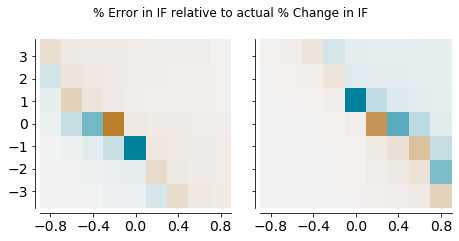

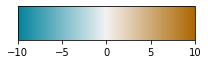

In [87]:
intersect = error_grid('error_IF',intersect)

fig, axes = plt.subplots(1,2, figsize = (6.5,3),sharex = True,  sharey = True)
intersect=intersect.sort_values('fI0',ascending=False)
fig.subplots_adjust(hspace = 5)
fig.suptitle('% Error in IF relative to actual % Change in IF',y=1.1)

binx=[-0.9,-0.7,-0.5,-0.3,-0.1,0.1,0.3,0.5,0.7,0.9]
biny = np.linspace(-3.75,3.75, 8)

intersect['x'] = (intersect['fI1']-intersect['fI0']).values.flatten()
x=intersect['x'].astype(float).values.flatten()
intersect['y'] = (intersect['P_Ks1']-intersect['P_Ks0']).values.flatten()
y=intersect['y'].astype(float).values.flatten()

z = intersect['min_err'].astype(float).values.flatten()
H, xedges, yedges, binnumbe=stats.binned_statistic_2d(x, y, values =z, statistic='min', bins=[binx, biny])
H = H.T # H is the density of values within each bin
# normalize H by H_sve_high_pct 
a=axes[0].pcolormesh(xedges, yedges,(H/H_sve_low_pct),lw=0,cmap=cmap,vmin=-10,vmax=10)
print(np.min(H/H_sve_low_pct))

z = intersect['max_err'].astype(float).values.flatten()
H, xedges, yedges, binnumbe=stats.binned_statistic_2d(x, y, values =z, statistic='max', bins=[binx, biny])
H = H.T # H is the density of values within each bin
a=axes[1].pcolormesh(xedges, yedges, (H/H_sve_high_pct),lw=0,cmap=cmap,vmin=-10,vmax=10)
print(np.max(H/H_sve_high_pct))

axes[1].set_xticks([-0.8,-0.4,0,0.4,0.8])

sns.despine(offset=5);

axe=axes.ravel()
for a in axe:
    for label in (a.get_xticklabels() + a.get_yticklabels()):
        label.set_fontsize(14)   
    
plt.tight_layout()
fig.subplots_adjust(wspace = .15)
file = os.path.join(parent_dir, 'figures\\error_IF_maxmin_norm.pdf')
# plt.savefig(file)

fig, axes = plt.subplots(1,figsize = (3,1))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=-10, vmax=10))
cbar = fig.colorbar(sm,orientation="horizontal",cax=axes )
for label in (axes.get_xticklabels() + axes.get_yticklabels()):
    plt.tight_layout()
file = os.path.join(parent_dir, 'figures\\IF_colorbar3_norm.pdf')
# plt.savefig(file)

### Absolute error in IF

-8.59616862734182
5.891548234578941


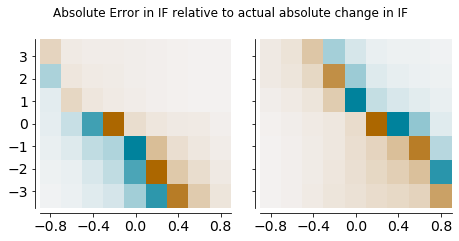

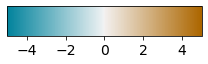

In [88]:
intersect = error_grid('error_IF_abs',intersect)

fig, axes = plt.subplots(1,2, figsize = (6.5,3),sharex = True,  sharey = True)
intersect=intersect.sort_values('fI0',ascending=False)
fig.subplots_adjust(hspace = 5)
fig.suptitle('Absolute Error in IF relative to actual absolute change in IF',y=1.1)


binx=[-0.9,-0.7,-0.5,-0.3,-0.1,0.1,0.3,0.5,0.7,0.9]
biny = np.linspace(-3.75,3.75, 8)

# intersect['y'] = (intersect['future_a']/np.max(intersect['future_a'])-(intersect['init_a']/np.max(intersect['init_a'])))
intersect['x'] = (intersect['fI1']-intersect['fI0']).values.flatten()
x=intersect['x'].astype(float).values.flatten()
intersect['y'] = (intersect['P_Ks1']-intersect['P_Ks0']).values.flatten()
y=intersect['y'].astype(float).values.flatten()


z = intersect['min_err'].astype(float).values.flatten()
H, xedges, yedges, binnumbe=stats.binned_statistic_2d(x, y, values =z, statistic='min', bins=[binx, biny])
H = H.T # H is the density of values within each bin
#normalize by SVE change
a=axes[0].pcolormesh(xedges, yedges, (H/H_IF_abs_low),lw=0,cmap=cmap,vmin=-5,vmax=5)
print(np.min(H/H_IF_abs_low))

z = intersect['max_err'].astype(float).values.flatten()
H, xedges, yedges, binnumbe=stats.binned_statistic_2d(x, y, values =z, statistic='max', bins=[binx, biny])
H = H.T # H is the density of values within each bin
#normalize by SVE change
a=axes[1].pcolormesh(xedges, yedges, (H/H_IF_abs_high),lw=0,cmap=cmap,vmin=-5,vmax=5)
print(np.max(H/H_IF_abs_high))

axes[1].set_xticks([-0.8,-0.4,0,0.4,0.8])

# plt.xlim(-1,1)
# plt.ylim(-3.25,3.25)

sns.despine(offset=5);

axe=axes.ravel()
for a in axe:
    for label in (a.get_xticklabels() + a.get_yticklabels()):
        label.set_fontsize(14)   


    
plt.tight_layout()
fig.subplots_adjust(wspace = .15)
file = os.path.join(parent_dir, 'figures\\error_IFabs_maxmin_norm.pdf')
# plt.savefig(file)

fig, axes = plt.subplots(1,figsize = (3,1))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=-5, vmax=5))
cbar = fig.colorbar(sm,orientation="horizontal",cax=axes )
for label in (axes.get_xticklabels() + axes.get_yticklabels()):
    label.set_fontsize(14)
plt.tight_layout()
file = os.path.join(parent_dir, 'figures\\IFabs_colorbar3_norm.pdf')
# plt.savefig(file)


### Absolute error in RD

-14.690029637610804
19.726328421721373


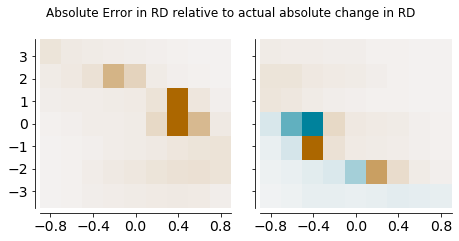

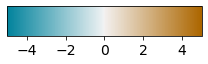

In [89]:
intersect = error_grid('error_RD_abs',intersect)

fig, axes = plt.subplots(1,2, figsize = (6.5,3),sharex = True,  sharey = True)
intersect=intersect.sort_values('fI0',ascending=False)
fig.subplots_adjust(hspace = 5)
fig.suptitle('Absolute Error in RD relative to actual absolute change in RD',y=1.1)


binx=[-0.9,-0.7,-0.5,-0.3,-0.1,0.1,0.3,0.5,0.7,0.9]
biny = np.linspace(-3.75,3.75, 8)

# intersect['y'] = (intersect['future_a']/np.max(intersect['future_a'])-(intersect['init_a']/np.max(intersect['init_a'])))
intersect['x'] = (intersect['fI1']-intersect['fI0']).values.flatten()
x=intersect['x'].astype(float).values.flatten()
intersect['y'] = (intersect['P_Ks1']-intersect['P_Ks0']).values.flatten()
y=intersect['y'].astype(float).values.flatten()


z = intersect['min_err'].astype(float).values.flatten()
H, xedges, yedges, binnumbe=stats.binned_statistic_2d(x, y, values =z, statistic='min', bins=[binx, biny])
H = H.T # H is the density of values within each bin
#normalize by SVE change
a=axes[0].pcolormesh(xedges, yedges, abs(H/H_RD_abs_low),lw=0,cmap=cmap,vmin=-5,vmax=5)
print(np.min(H/H_RD_abs_low))

z = intersect['max_err'].astype(float).values.flatten()
H, xedges, yedges, binnumbe=stats.binned_statistic_2d(x, y, values =z, statistic='max', bins=[binx, biny])
H = H.T # H is the density of values within each bin
#normalize by SVE change
a=axes[1].pcolormesh(xedges, yedges, (H/H_RD_abs_high),lw=0,cmap=cmap,vmin=-5,vmax=5)
print(np.max(H/H_RD_abs_high))

axes[1].set_xticks([-0.8,-0.4,0,0.4,0.8])


sns.despine(offset=5);

axe=axes.ravel()
for a in axe:
    for label in (a.get_xticklabels() + a.get_yticklabels()):
        label.set_fontsize(14)   


    
plt.tight_layout()
fig.subplots_adjust(wspace = .15)
file = os.path.join(parent_dir, 'figures\\error_VQ_maxmin_norm.pdf')
# plt.savefig(file)

fig, axes = plt.subplots(1,figsize = (3,1))
sm = plt.cm.ScalarMappable(cmap=cmap,norm=plt.Normalize(vmin=-5, vmax=5))
cbar = fig.colorbar(sm,orientation="horizontal",cax=axes )
for label in (axes.get_xticklabels() + axes.get_yticklabels()):
    label.set_fontsize(14)
plt.tight_layout()
file = os.path.join(parent_dir, 'figures\\VQ_colorbar3_norm.pdf')
# plt.savefig(file)


In [90]:
#check max and min relative error in RD 

#for d_pKs = 0 (i.e., no change in p or ks)
dum=intersect[intersect['d_PKs']==0]

#for a small increase in impervoius
dum1=dum[dum['fI0']==0.7] 
dum1=dum1[dum1['fI1']==0.9]
print('range of relative error in RD for small increase in impervious') 
print( 'max = ' +str(np.round(dum1['max_err'].max(),2)), 'min = ' + str(np.round(dum1['min_err'].min(),2)))
print('--------')
#for a large increase in impervoius
dum1=dum[dum['d_fI']==0.8] # for max possible d_fI
print('range of relative error in RD for large increase in impervious') 
print( 'max = ' +str(np.round(dum1['max_err'].max(),2)), 'min = ' + str(np.round(dum1['min_err'].min(),2)))


range of relative error in RD for small increase in impervious
max = 0.98 min = -1.21
--------
range of relative error in RD for large increase in impervious
max = 0.97 min = -1.5


# case study: errors in non-transferrable sets


In [91]:
#define case study conditions

initial_conditions={'p_Ks':.25,'fI':0.1}
developed_conditions={'p_Ks':.25,'fI':0.9}
climate_conditions={'p_Ks':4,'fI':0.1}
dev_clim_conditions={'p_Ks':4,'fI':0.9}

### plot PE_IF errors

In [92]:
from shapely.geometry import Point, Polygon,MultiPoint
axis_font12 = { 'size':'12','fontname':'Myriad Pro',}

def plot_intersected_pts(initial_conditions,final_conditions,error_metric):
    point_list=[]
    initial_poly = poly_df[poly_df.fI ==initial_conditions['fI']]
    initial_poly = initial_poly[initial_poly.scenario ==initial_conditions['p_Ks']]
    initial_poly=np.unique(initial_poly['poly'])[0]
    final_poly = poly_df[poly_df.fI ==final_conditions['fI']]
    final_poly = final_poly[final_poly.scenario ==final_conditions['p_Ks']]
    final_poly=np.unique(final_poly['poly'])[0]

    final_pts=core_wadc[core_wadc.fI ==final_conditions['fI']]
    final_pts=final_pts[final_pts.p_Ks ==final_conditions['p_Ks']].sort_values(error_metric,ascending=False)

    
    fig, axes = plt.subplots(2,1, figsize = (5,7))
    
    for index,row in final_pts.iterrows():
        K_width=row['K_width']
        f_dc=row['f_dc']
        error=row[error_metric]
        orig = (K_width,f_dc,error)
        point_list=point_list+[orig]
    multi_pts = MultiPoint(point_list)

    error=[]
    int_points=[]
    for p in multi_pts:
        if p.within(initial_poly):
            c=str(0.5-np.round(p.z/100.,2)/0.5)
#             axes[0].plot(p.x, p.y, 'o', color=c,linewidth=0,alpha=0.5)
            int_points=int_points+[p]
            error=error+[(p.z)]
    
    
    sns.scatterplot(data=final_pts.sort_values(error_metric,ascending=False),x='K_width', y='f_dc', hue=error_metric,
                    ax=axes[0],palette=cmap,edgecolor=None,legend=False,vmin=-60,vmax=60)
    patchi=PolygonPatch(initial_poly,color='grey',alpha=0.5,zorder=4)
    patchio = PolygonPatch(initial_poly,facecolor=None,edgecolor='k',fill=False,lw=2,ls='--',zorder=5)
    patchf=PolygonPatch(final_poly,facecolor=None,fill=False,hatch='//',alpha=0.5,zorder=6)
    patchfo=PolygonPatch(final_poly,facecolor=None,edgecolor='k',fill=False,lw=2,ls='--',zorder=6)
    for index,patch in enumerate([patchi,patchio,patchf,patchfo]):
        axes[0].add_patch(patch)
#     axes[1].text(-45,550,"Range $D_{IF}$ = " + str(np.round(np.min(error),1)) + " to " + str(np.round(np.max(error),1))+'%',
#                  **axis_font)
#     axes[1].text(-45,450,"Std $D_{IF}$ = +/-" + str(np.round(np.std(error),1))+'%',**axis_font)
    axes[0].set_xlim(0.00,.11)
#     axes[0].set_ylim(0,.5)
    axes[0].set_ylabel('$ɸ_{idc}$',**axis_font)
    axes[1].set_ylabel('Density',**axis_font)
    axes[0].set_xlabel('$k_{width}$',**axis_font)
    axes[1].set_xlabel('$D_{IF}$',**axis_font)

    axes[1].set_ylim(0,.1)
    bins=np.int(abs(np.max(error)-np.min(error))/5.)
    sns.kdeplot(error,ax=axes[1],color='black')      
#     sns.histplot(data=error, kde=True,ax=axes[1],)
#     axes[1].hist(error,edgecolor='black', color='grey', zorder=2)
                 # confidence intervals
    alpha = 0.95
    p = ((1.0-alpha)/2.0) * 100
    lower =  np.percentile(error, p)
    p = (alpha+((1.0-alpha)/2.0)) * 100
    upper =  np.percentile(error, p)
    axes[1].axvline(x=upper,ymax=0.8, color='black',ls='--')
    axes[1].axvline(x=lower,ymax=0.8, color='black',ls='--')
    mean=np.mean(error)
    axes[1].axvline(x=mean,ymax=0.8, color='red',ls='--')

#     median =  np.percentile(error, 50)
#     axes[1].axvline(x=median,ymax=0.8, color='red',ls='--')
    if initial_conditions==final_conditions:
        axes[1].set_xlim(-10,10)
        axes[1].set_ylim(0,.25)
        print(lower,np.mean(error),upper)

        
    else:
        axes[1].set_xlim(-60,60)
        axes[1].set_ylim(0,.06)

        print(lower,np.mean(error),upper)

    axes[1].tick_params(labelsize=14)
    axes[0].tick_params(labelsize=14)
    sns.despine(offset=10, trim=True);
    plt.tight_layout()

0.14385415286914724 3.148975957891159 6.218754939942567
-26.055200393907175 1.6859044364809468 19.094619587764683
-27.82771846800458 4.197339044491036 16.577047639680497
-13.057510310407672 20.205134752930977 35.17679396061281


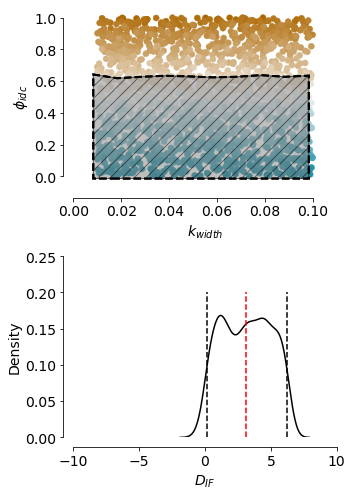

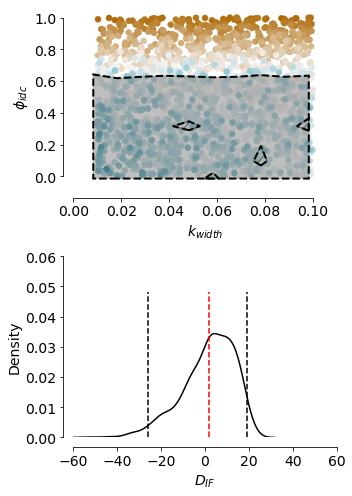

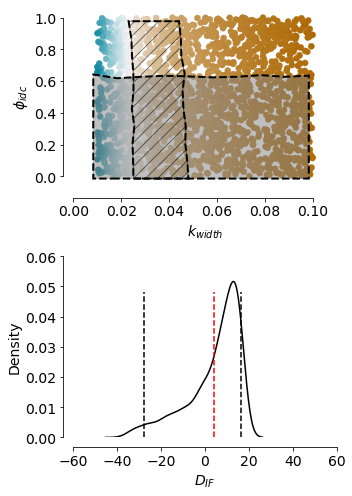

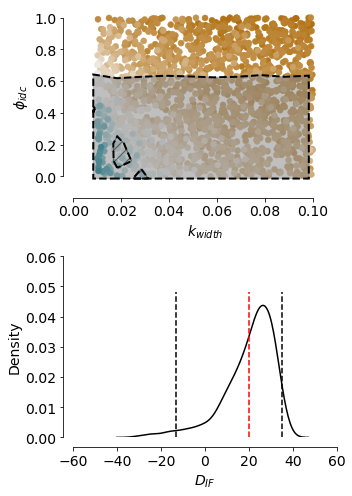

In [93]:

plot_intersected_pts(initial_conditions,initial_conditions,"error_IF_pct")
file = os.path.join(parent_dir, 'figures\\initial_hist.pdf')
plt.savefig(file)

plot_intersected_pts(initial_conditions,developed_conditions,"error_IF_pct")
file = os.path.join(parent_dir, 'figures\\developed_hist.pdf')
plt.savefig(file)

plot_intersected_pts(initial_conditions,climate_conditions,"error_IF_pct")
file = os.path.join(parent_dir, 'figures\\cc_hist.pdf')
plt.savefig(file)

plot_intersected_pts(initial_conditions,dev_clim_conditions,"error_IF_pct")
file = os.path.join(parent_dir, 'figures\\dev_cc_hist.pdf')
plt.savefig(file)


### Same function, but for  runoff depth

In [94]:
from shapely.geometry import Point, Polygon,MultiPoint
axis_font12 = { 'size':'12','fontname':'Myriad Pro',}

def plot_intersected_pts(initial_conditions,final_conditions,error_metric):
    point_list=[]
    initial_poly = poly_df[poly_df.fI ==initial_conditions['fI']]
    initial_poly = initial_poly[initial_poly.scenario ==initial_conditions['p_Ks']]
    initial_poly=np.unique(initial_poly['poly'])[0]
    final_poly = poly_df[poly_df.fI ==final_conditions['fI']]
    final_poly = final_poly[final_poly.scenario ==final_conditions['p_Ks']]
    final_poly=np.unique(final_poly['poly'])[0]

    final_pts=core_wadc[core_wadc.fI ==final_conditions['fI']]
    final_pts=final_pts[final_pts.p_Ks ==final_conditions['p_Ks']].sort_values(error_metric,ascending=False)

    
    fig, axes = plt.subplots(2,1, figsize = (5,7))
    
    for index,row in final_pts.iterrows():
        K_width=row['K_width']
        f_dc=row['f_dc']
        error=row[error_metric]
        orig = (K_width,f_dc,error)
        point_list=point_list+[orig]
    multi_pts = MultiPoint(point_list)

    error=[]
    int_points=[]
    for p in multi_pts:
        if p.within(initial_poly):
            c=str(0.5-np.round(p.z/100.,2)/0.5)
#             axes[0].plot(p.x, p.y, 'o', color=c,linewidth=0,alpha=0.5)
            int_points=int_points+[p]
            error=error+[(p.z)]
    
    
    sns.scatterplot(data=final_pts.sort_values(error_metric,ascending=False),x='K_width', y='f_dc', hue=error_metric,
                    ax=axes[0],palette=cmap,edgecolor=None,legend=False,vmin=-5,vmax=5)
    patchi=PolygonPatch(initial_poly,color='grey',alpha=0.5,zorder=4)
    patchio = PolygonPatch(initial_poly,facecolor=None,edgecolor='k',fill=False,lw=2,ls='--',zorder=5)
    patchf=PolygonPatch(final_poly,facecolor=None,fill=False,hatch='//',alpha=0.5,zorder=6)
    patchfo=PolygonPatch(final_poly,facecolor=None,edgecolor='k',fill=False,lw=2,ls='--',zorder=6)
    for index,patch in enumerate([patchi,patchio,patchf,patchfo]):
        axes[0].add_patch(patch)
#     axes[1].text(-45,550,"Range $D_{IF}$ = " + str(np.round(np.min(error),1)) + " to " + str(np.round(np.max(error),1))+'%',
#                  **axis_font)
#     axes[1].text(-45,450,"Std $D_{IF}$ = +/-" + str(np.round(np.std(error),1))+'%',**axis_font)
    axes[0].set_xlim(0.00,.11)
#     axes[0].set_ylim(0,.5)
    axes[0].set_ylabel('$ɸ_{idc}$',**axis_font)
    axes[1].set_ylabel('Density',**axis_font)
    axes[0].set_xlabel('$k_{width}$',**axis_font)
    axes[1].set_xlabel('$D_{IF}$',**axis_font)

    axes[1].set_ylim(0,.1)
    bins=np.int(abs(np.max(error)-np.min(error))/5.)
    sns.kdeplot(error,ax=axes[1],color='black')      
#     sns.histplot(data=error, kde=True,ax=axes[1],)
#     axes[1].hist(error,edgecolor='black', color='grey', zorder=2)
                 # confidence intervals
    alpha = 0.95
    p = ((1.0-alpha)/2.0) * 100
    lower =  np.percentile(error, p)
    p = (alpha+((1.0-alpha)/2.0)) * 100
    upper =  np.percentile(error, p)
    axes[1].axvline(x=upper,ymax=0.8, color='black',ls='--')
    axes[1].axvline(x=lower,ymax=0.8, color='black',ls='--')
    mean=np.mean(error)
    axes[1].axvline(x=mean,ymax=0.8, color='red',ls='--')

#     median =  np.percentile(error, 50)
#     axes[1].axvline(x=median,ymax=0.8, color='red',ls='--')
    if initial_conditions==final_conditions:
        axes[1].set_xlim(-2,2)
        axes[1].set_ylim(0,2)

        print(lower,np.mean(error),upper)

        
    else:
        axes[1].set_xlim(-5,5)
        axes[1].set_ylim(0,1.5)

        print(lower,np.mean(error),upper)


    axes[1].tick_params(labelsize=14)
    axes[0].tick_params(labelsize=14)
    sns.despine(offset=10, trim=True);
    plt.tight_layout()

-0.6224381389221334 -0.3148780017472359 -0.014320494784648662
-0.9934203260036577 -0.12478471805518263 0.9731607655720513
-2.3324580870841083 -0.5894625523512343 3.909671920304669
-0.6689174436208958 -0.37359353929161065 0.2504673722137733


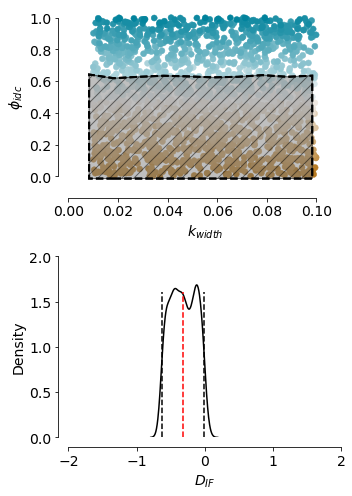

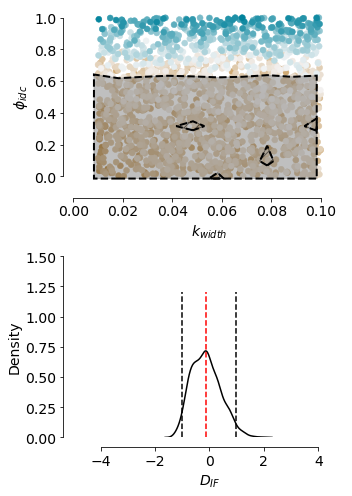

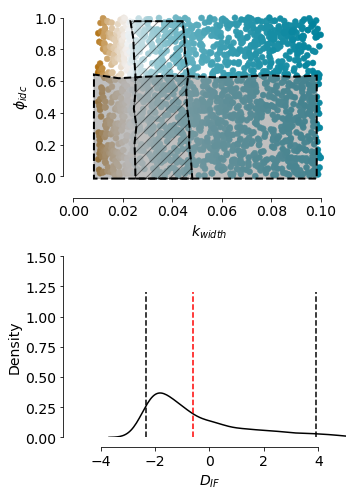

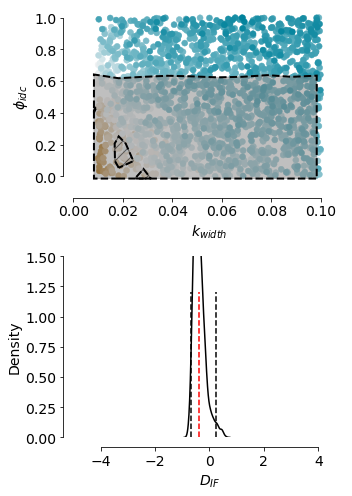

In [95]:
plot_intersected_pts(initial_conditions,initial_conditions,"error_RD_abs")
file = os.path.join(parent_dir, 'figures\\initial_hist_RD.pdf')
plt.savefig(file)

plot_intersected_pts(initial_conditions,developed_conditions,"error_RD_abs")
file = os.path.join(parent_dir, 'figures\\developed_hist_RD.pdf')
plt.savefig(file)

plot_intersected_pts(initial_conditions,climate_conditions,"error_RD_abs")
file = os.path.join(parent_dir, 'figures\\cc_hist_RD.pdf')
plt.savefig(file)

plot_intersected_pts(initial_conditions,dev_clim_conditions,"error_RD_abs")
file = os.path.join(parent_dir, 'figures\\dev_cc_hist_RD.pdf')
plt.savefig(file)